# Preprocessing

In [27]:
#Import dependencies.

import pandas as pd
import time
import numpy as np
import calendar
import plotly.express as px
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [28]:
t1 = time.time()
df = pd.read_csv('Motor_Vehicle_Collisions_Crashes.csv')
df['TIME'] = df['CRASH DATE'] + ' ' + df['CRASH TIME']
df['TIME'] = pd.to_datetime(df['TIME'], format="%m/%d/%Y %H:%M")
t2 = time.time()

#Discard observations where LOCATION is missing.
df = df.loc[~df['LOCATION'].isna()]
df = df.loc[~(df['LOCATION'] == '(0.0, 0.0)')]

df['ZIP CODE'] = df['ZIP CODE'].replace({'     ' : np.nan}).astype(float)
#df['ZIP CODE'] = df['ZIP CODE'].astype(float).fillna(0).astype(int)

#Discard 2012 and 2021. 
df = df.loc[(df['TIME'].dt.year > 2012) & (df['TIME'].dt.year < 2021)]
print(f'Time elapsed: {t2-t1} seconds.')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.



Time elapsed: 16.398566007614136 seconds.


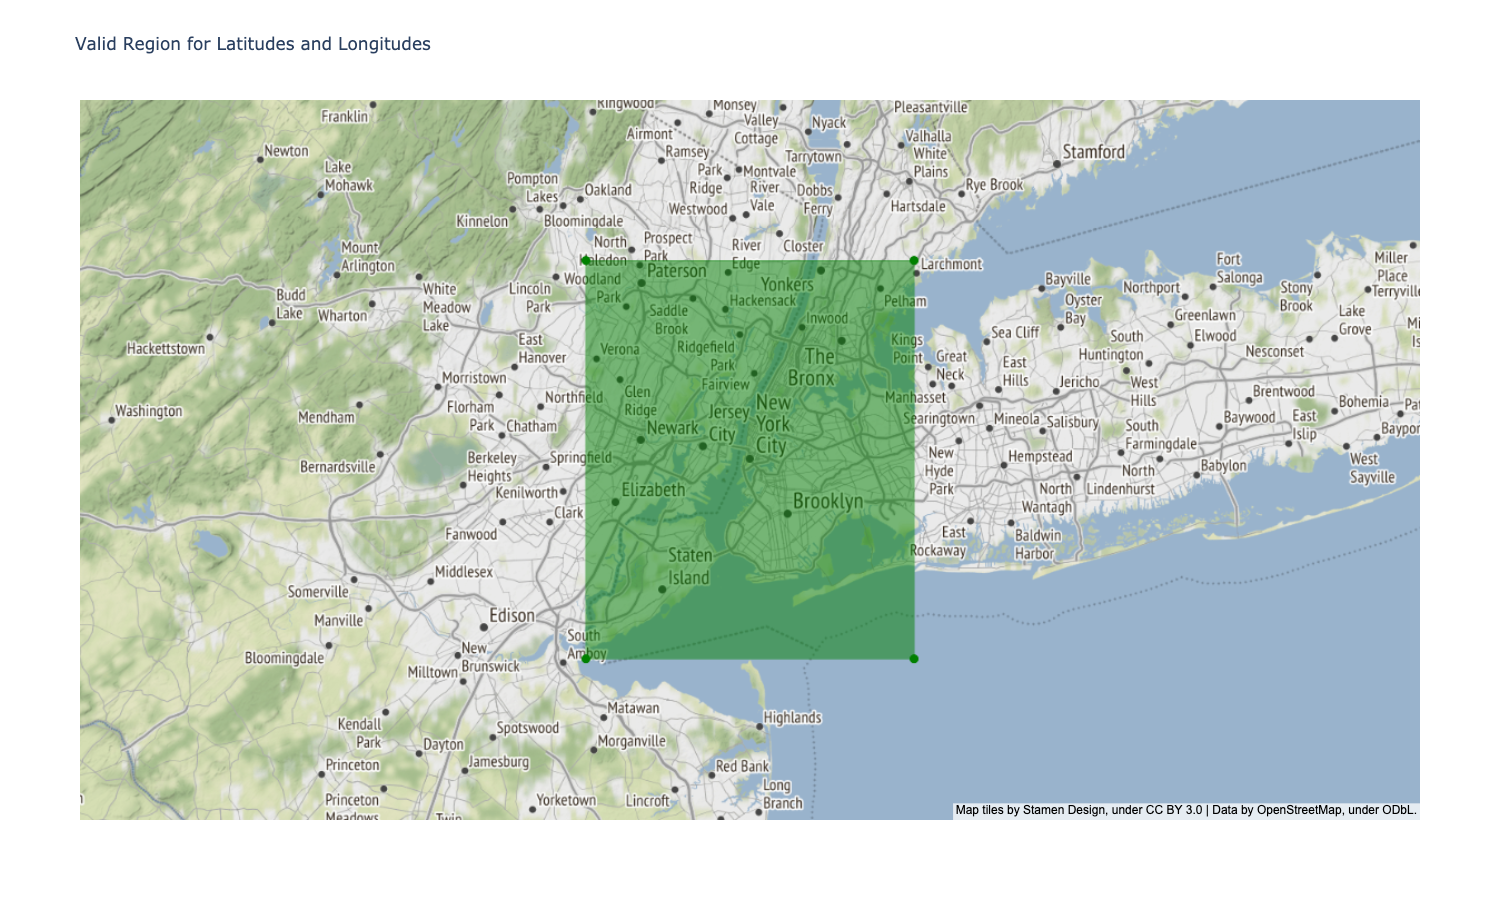

In [29]:
import plotly.graph_objects as go
lon_center = -74.006058
lat_center = 40.712772
lat_width = 0.23
lon_width  = 0.25

fig = go.Figure(go.Scattermapbox(
    fill = "toself",
    lon = [lon_center-lon_width, lon_center+lon_width, lon_center+lon_width, lon_center-lon_width], lat = [lat_center+lat_width, lat_center+lat_width, lat_center-lat_width, lat_center-lat_width],
    marker = { 'size': 10, 'color': "green" }))

fig.update_layout(
    mapbox = {
        'style': "stamen-terrain",
        'center': {'lon': -74.006058, 'lat': 40.712772},
        'zoom': 8.85},
    showlegend = False, width=1200, height=900, title='Valid Region for Latitudes and Longitudes')

fig.show()
fig.write_html("./plotly_html/valid_area.html")

df = df.loc[(df['LONGITUDE'] >= lon_center - lon_width) & 
            (df['LONGITUDE'] <= lon_center + lon_width) & 
            (df['LATITUDE']  >= lat_center - lat_width) & 
            (df['LATITUDE'] <= lat_center + lat_width)]

## Adding new columns

We wish to add a column specifying whether or not any was injured or killed.



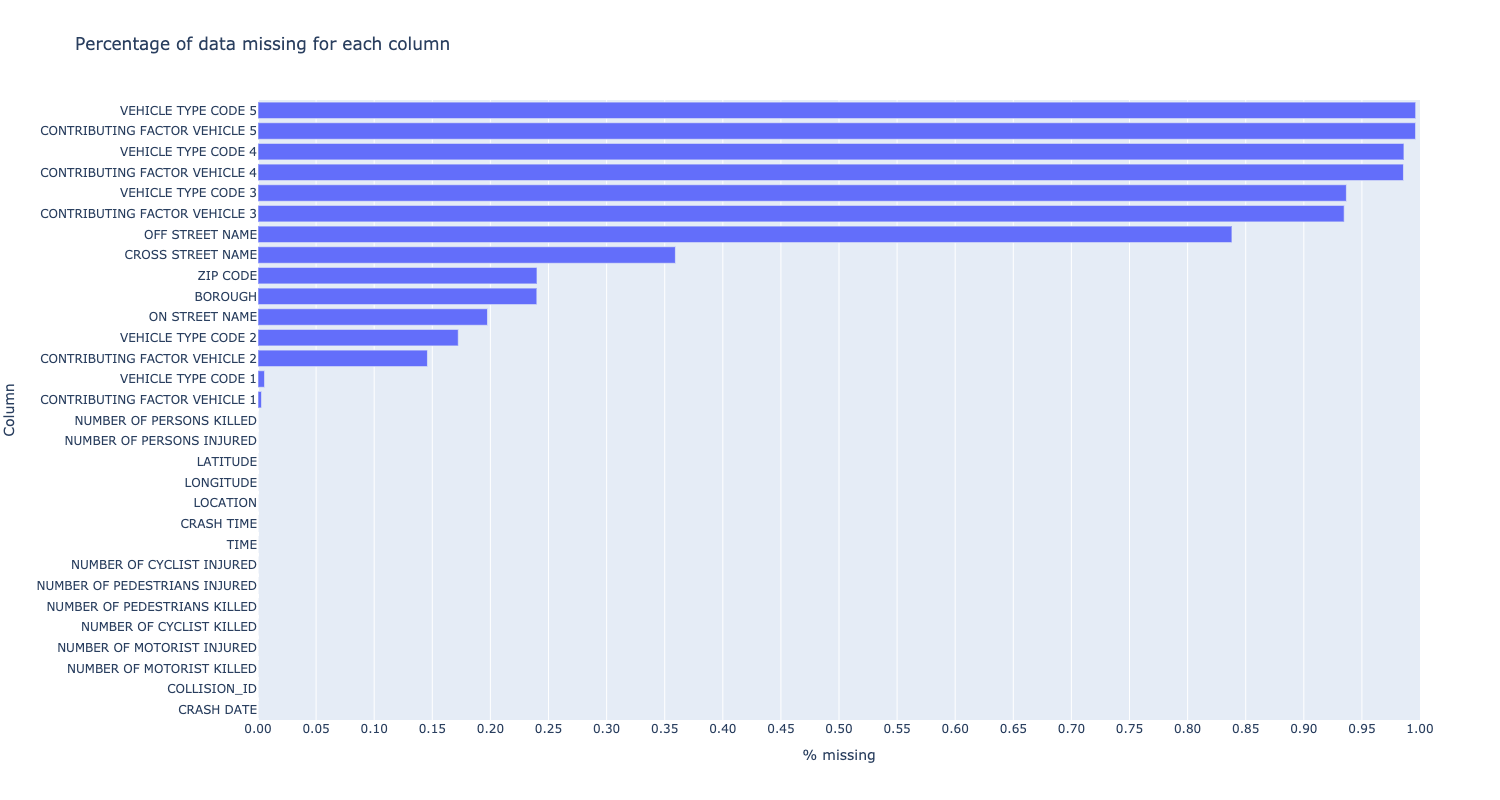

In [30]:
missing_pct_df = pd.DataFrame((df.isnull().sum(axis=0)/len(df)).sort_values(ascending=True)).reset_index(); missing_pct_df.columns = ['Column', 'Percentage missing']

import plotly.express as px
fig = px.bar(missing_pct_df, x="Percentage missing", y="Column", orientation='h', width = 1000, height=800, title='Percentage of data missing for each column')
fig.update_layout(
    xaxis_title="% missing",
    xaxis = dict(
        tickmode = 'array',
        tickvals = np.arange(0,1.05,0.05),
        ticktext = ['{0:.2f}'.format(x) for x in np.arange(0, 1.05, 0.05)]
    )
)
fig.update_xaxes(range=[0, 1], row=1, col=1)

fig.show()
fig.write_html("./plotly_html/pct_missing.html")

## Filling in Missing Borough and ZIP Codes

In [31]:
(_, data_complete), (_, data_missing) = df.groupby(np.any(pd.isna(df[['ZIP CODE', 'BOROUGH']]), axis=1))

In [32]:
print(f'Number of rows with either BOROUGH or ZIP CODE missing: {len(data_missing)}\n')
data_missing.head()

Number of rows with either BOROUGH or ZIP CODE missing: 334840



,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,TIME
217,12/18/2020,21:55,NaN,NaN,40.695970,-73.913370,"(40.69597, -73.91337)",KNICKERBOCKER AVENUE,NaN,NaN,...,NaN,NaN,NaN,4377213,Sedan,NaN,NaN,NaN,NaN,2020-12-18 21:55:00
232,12/11/2020,14:43,NaN,NaN,40.843246,-73.945050,"(40.843246, -73.94505)",HENRY HUDSON PARKWAY,NaN,NaN,...,NaN,NaN,NaN,4375744,Sedan,NaN,NaN,NaN,NaN,2020-12-11 14:43:00
237,12/08/2020,2:00,NaN,NaN,40.865100,-73.921890,"(40.8651, -73.92189)",SHERMAN AVENUE,NaN,NaN,...,NaN,NaN,NaN,4374133,Sedan,Sedan,NaN,NaN,NaN,2020-12-08 02:00:00
238,12/07/2020,10:00,NaN,NaN,40.820827,-73.950836,"(40.820827, -73.950836)",WEST 138 STREET,NaN,NaN,...,NaN,NaN,NaN,4374340,Sedan,NaN,NaN,NaN,NaN,2020-12-07 10:00:00
243,12/05/2020,13:45,NaN,NaN,40.651863,-73.865360,"(40.651863, -73.86536)",BELT PARKWAY,NaN,NaN,...,Unspecified,NaN,NaN,4373337,Sedan,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,2020-12-05 13:45:00


In [33]:
print(f'Number of rows with both BOROUGH and ZIP CODE: {len(data_complete)}\n')
data_complete.head()

Number of rows with both BOROUGH and ZIP CODE: 1059705



,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,TIME
199,12/28/2020,17:28,BRONX,10456.0,40.824066,-73.908714,"(40.824066, -73.908714)",3 AVENUE,EAST 163 STREET,NaN,...,NaN,NaN,NaN,4379833,Sedan,Sedan,NaN,NaN,NaN,2020-12-28 17:28:00
218,12/17/2020,14:43,QUEENS,11368.0,40.747650,-73.863010,"(40.74765, -73.86301)",NaN,NaN,102-02 42 AVENUE,...,NaN,NaN,NaN,4376945,Tractor Truck Gasoline,NaN,NaN,NaN,NaN,2020-12-17 14:43:00
221,12/15/2020,11:00,MANHATTAN,10002.0,40.713920,-73.991714,"(40.71392, -73.991714)",NaN,NaN,129 EAST BROADWAY,...,NaN,NaN,NaN,4376264,Sedan,NaN,NaN,NaN,NaN,2020-12-15 11:00:00
224,12/14/2020,17:11,BRONX,10459.0,40.820990,-73.895890,"(40.82099, -73.89589)",KELLY STREET,EAST 163 STREET,NaN,...,NaN,NaN,NaN,4376147,Sedan,NaN,NaN,NaN,NaN,2020-12-14 17:11:00
236,12/08/2020,19:52,BROOKLYN,11229.0,40.599728,-73.937920,"(40.599728, -73.93792)",NaN,NaN,2152 FORD STREET,...,NaN,NaN,NaN,4374372,Sedan,NaN,NaN,NaN,NaN,2020-12-08 19:52:00


Even with the complete data, the police seems to have some issues regarding which zip codes belong where.

In [34]:
counts = data_complete.groupby(['ZIP CODE', 'BOROUGH']).size().reset_index(); counts.columns = ['ZIP CODE', 'BOROUGH', 'COUNT']
zips, n = np.unique(counts['ZIP CODE'], return_counts=True)
counts.loc[counts['ZIP CODE'].apply(lambda x : x in zips[n > 1])]

,ZIP CODE,BOROUGH,COUNT
140,11208.0,BROOKLYN,12337
141,11208.0,QUEENS,156
169,11237.0,BROOKLYN,6367
170,11237.0,QUEENS,280
201,11385.0,BROOKLYN,30
202,11385.0,QUEENS,13513
213,11421.0,BROOKLYN,6
214,11421.0,QUEENS,4208


We can see out of the 12493 observations with ZIP CODE 11208, 156 of them were in Queens and 12337 of them were in Brooklyn. 
With these cases, we are going to let the majority of the observations decide which borough is the correct one. From the table above, we can see that we have a total of **472** observations with the wrong borough.

In [35]:
#We make a mapping between zip code and the correct borough.
zip_to_borough = {}
for zip_, subset in counts.groupby('ZIP CODE'):
    zip_to_borough[zip_] = subset.sort_values('COUNT', ascending=False)['BOROUGH'].iloc[0]
    
correct_boroughs = data_complete['ZIP CODE'].replace(zip_to_borough)
n_remaps = (correct_boroughs != data_complete['BOROUGH']).sum()
print(f'We have remapped {n_remaps} observations.')

data_complete['BOROUGH'] = correct_boroughs

We have remapped 472 observations.


In [36]:
data_complete.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,TIME
199,12/28/2020,17:28,BRONX,10456.0,40.824066,-73.908714,"(40.824066, -73.908714)",3 AVENUE,EAST 163 STREET,NaN,...,NaN,NaN,NaN,4379833,Sedan,Sedan,NaN,NaN,NaN,2020-12-28 17:28:00
218,12/17/2020,14:43,QUEENS,11368.0,40.747650,-73.863010,"(40.74765, -73.86301)",NaN,NaN,102-02 42 AVENUE,...,NaN,NaN,NaN,4376945,Tractor Truck Gasoline,NaN,NaN,NaN,NaN,2020-12-17 14:43:00
221,12/15/2020,11:00,MANHATTAN,10002.0,40.713920,-73.991714,"(40.71392, -73.991714)",NaN,NaN,129 EAST BROADWAY,...,NaN,NaN,NaN,4376264,Sedan,NaN,NaN,NaN,NaN,2020-12-15 11:00:00
224,12/14/2020,17:11,BRONX,10459.0,40.820990,-73.895890,"(40.82099, -73.89589)",KELLY STREET,EAST 163 STREET,NaN,...,NaN,NaN,NaN,4376147,Sedan,NaN,NaN,NaN,NaN,2020-12-14 17:11:00
236,12/08/2020,19:52,BROOKLYN,11229.0,40.599728,-73.937920,"(40.599728, -73.93792)",NaN,NaN,2152 FORD STREET,...,NaN,NaN,NaN,4374372,Sedan,NaN,NaN,NaN,NaN,2020-12-08 19:52:00


In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

Xtrain = data_complete[['LATITUDE', 'LONGITUDE']].values
ytrain = le.fit_transform(data_complete['ZIP CODE'].to_numpy())

clf = KNeighborsClassifier(n_neighbors = 3)
clf.fit(Xtrain,ytrain)

Ximpute = data_missing[['LATITUDE', 'LONGITUDE']].values
yimpute = le.inverse_transform(clf.predict(Ximpute))

In [38]:
data_missing.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,TIME
217,12/18/2020,21:55,NaN,NaN,40.695970,-73.913370,"(40.69597, -73.91337)",KNICKERBOCKER AVENUE,NaN,NaN,...,NaN,NaN,NaN,4377213,Sedan,NaN,NaN,NaN,NaN,2020-12-18 21:55:00
232,12/11/2020,14:43,NaN,NaN,40.843246,-73.945050,"(40.843246, -73.94505)",HENRY HUDSON PARKWAY,NaN,NaN,...,NaN,NaN,NaN,4375744,Sedan,NaN,NaN,NaN,NaN,2020-12-11 14:43:00
237,12/08/2020,2:00,NaN,NaN,40.865100,-73.921890,"(40.8651, -73.92189)",SHERMAN AVENUE,NaN,NaN,...,NaN,NaN,NaN,4374133,Sedan,Sedan,NaN,NaN,NaN,2020-12-08 02:00:00
238,12/07/2020,10:00,NaN,NaN,40.820827,-73.950836,"(40.820827, -73.950836)",WEST 138 STREET,NaN,NaN,...,NaN,NaN,NaN,4374340,Sedan,NaN,NaN,NaN,NaN,2020-12-07 10:00:00
243,12/05/2020,13:45,NaN,NaN,40.651863,-73.865360,"(40.651863, -73.86536)",BELT PARKWAY,NaN,NaN,...,Unspecified,NaN,NaN,4373337,Sedan,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,2020-12-05 13:45:00


In [39]:
data_missing['ZIP CODE'] = yimpute
data_missing['BOROUGH']  = data_missing['ZIP CODE'].replace(zip_to_borough)

In [40]:
data_missing.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,TIME
217,12/18/2020,21:55,BROOKLYN,11221.0,40.695970,-73.913370,"(40.69597, -73.91337)",KNICKERBOCKER AVENUE,NaN,NaN,...,NaN,NaN,NaN,4377213,Sedan,NaN,NaN,NaN,NaN,2020-12-18 21:55:00
232,12/11/2020,14:43,MANHATTAN,10032.0,40.843246,-73.945050,"(40.843246, -73.94505)",HENRY HUDSON PARKWAY,NaN,NaN,...,NaN,NaN,NaN,4375744,Sedan,NaN,NaN,NaN,NaN,2020-12-11 14:43:00
237,12/08/2020,2:00,MANHATTAN,10034.0,40.865100,-73.921890,"(40.8651, -73.92189)",SHERMAN AVENUE,NaN,NaN,...,NaN,NaN,NaN,4374133,Sedan,Sedan,NaN,NaN,NaN,2020-12-08 02:00:00
238,12/07/2020,10:00,MANHATTAN,10031.0,40.820827,-73.950836,"(40.820827, -73.950836)",WEST 138 STREET,NaN,NaN,...,NaN,NaN,NaN,4374340,Sedan,NaN,NaN,NaN,NaN,2020-12-07 10:00:00
243,12/05/2020,13:45,BROOKLYN,11234.0,40.651863,-73.865360,"(40.651863, -73.86536)",BELT PARKWAY,NaN,NaN,...,Unspecified,NaN,NaN,4373337,Sedan,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,2020-12-05 13:45:00


In [89]:
data_missing.shape

(334840, 30)

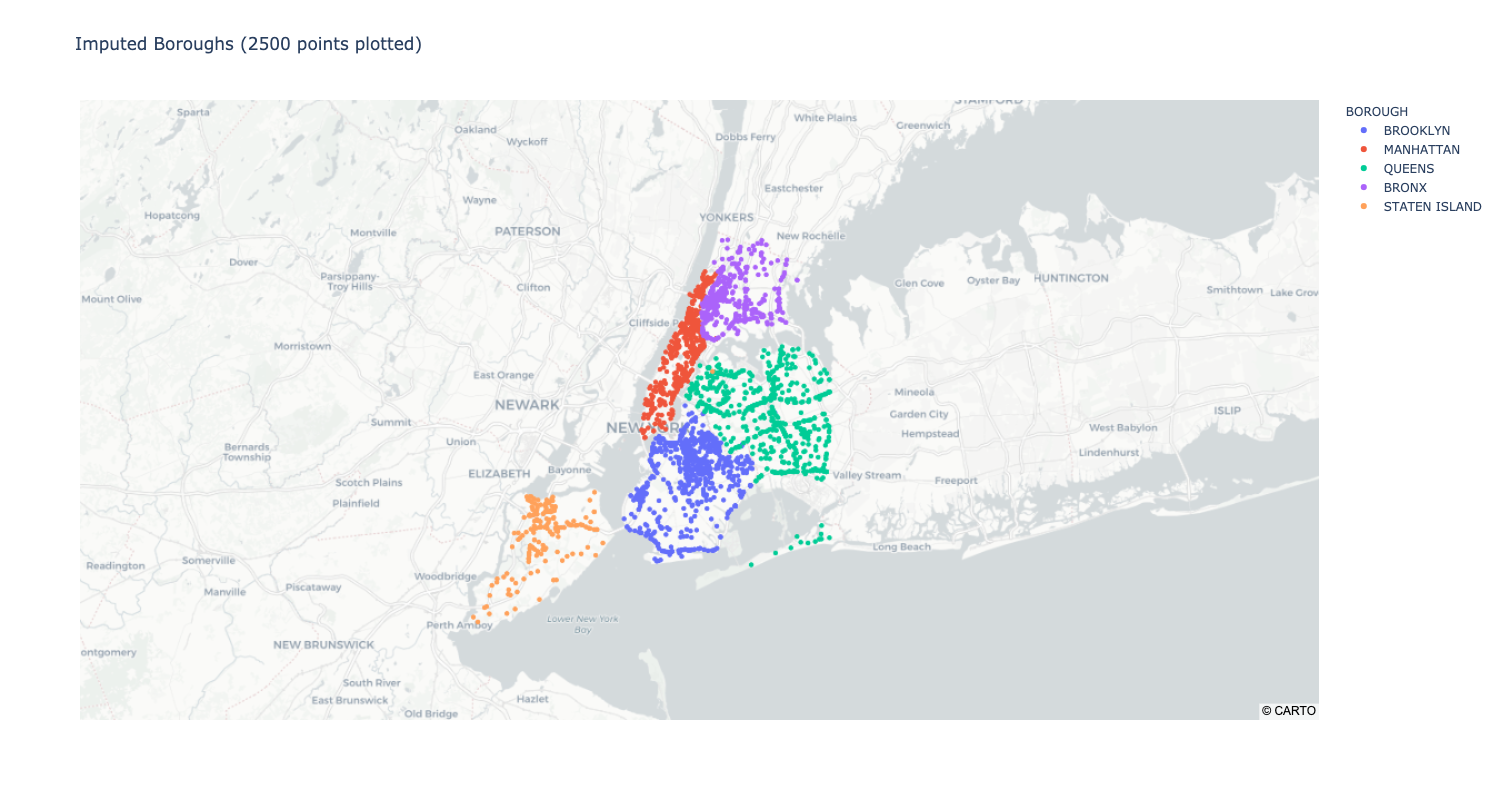

In [96]:
import plotly.express as px
fig = px.scatter_mapbox(data_missing[:2500], lat='LATITUDE', lon='LONGITUDE', color='BOROUGH',
                        center=dict(lat=40.730610, lon=-73.935242), zoom=9,
                        mapbox_style="carto-positron",
                       width = 800, height = 800, title='Imputed Boroughs (2500 points plotted)')
fig.show()
fig.write_html("./plotly_html/KNN_imputer.html")

In [211]:
df = data_complete.append(data_missing)

If contributing factor vehicle 1 is nan, then fill it with unspecified.

In [235]:
df['CONTRIBUTING FACTOR VEHICLE 1'] = df['CONTRIBUTING FACTOR VEHICLE 1'].fillna('Unspecified')

# Preprocess Contributing Factors


In [237]:
unique_factors = np.unique(df[[f'CONTRIBUTING FACTOR VEHICLE {i}' for i in range(1,6)]].values.reshape(-1,).astype(str))

In [252]:
for i, factor in enumerate(unique_factors):
    df[f'CF_{factor}'] = df[[f'CONTRIBUTING FACTOR VEHICLE {i}' for i in range(1,6)]].astype(str).apply(lambda x : factor in list(x), axis=1).astype(int)
    print(f'#{i+1}/{len(unique_factors)}: {factor} done')
    

df = df.loc[df['NUMBER OF PERSONS KILLED'].fillna(0) == df[[x for x in df.columns if x.endswith('KILLED') and x.find('PERSONS')==-1]].sum(axis=1)]
df = df.loc[df['NUMBER OF PERSONS INJURED'].fillna(0) == df[[x for x in df.columns if x.endswith('INJURED') and x.find('PERSONS')==-1]].sum(axis=1)]

df.to_csv('preprocessed_collisions.csv', index=False)

#1/62: 1 done
#2/62: 80 done
#3/62: Accelerator Defective done
#4/62: Aggressive Driving/Road Rage done
#5/62: Alcohol Involvement done
#6/62: Animals Action done
#7/62: Backing Unsafely done
#8/62: Brakes Defective done
#9/62: Cell Phone (hand-Held) done
#10/62: Cell Phone (hand-held) done
#11/62: Cell Phone (hands-free) done
#12/62: Driver Inattention/Distraction done
#13/62: Driver Inexperience done
#14/62: Driverless/Runaway Vehicle done
#15/62: Drugs (Illegal) done
#16/62: Drugs (illegal) done
#17/62: Eating or Drinking done
#18/62: Failure to Keep Right done
#19/62: Failure to Yield Right-of-Way done
#20/62: Fatigued/Drowsy done
#21/62: Fell Asleep done
#22/62: Following Too Closely done
#23/62: Glare done
#24/62: Headlights Defective done
#25/62: Illnes done
#26/62: Illness done
#27/62: Lane Marking Improper/Inadequate done
#28/62: Listening/Using Headphones done
#29/62: Lost Consciousness done
#30/62: Obstruction/Debris done
#31/62: Other Electronic Device done
#32/62: Other Li

In [166]:
df = pd.read_csv('preprocessed_collisions.csv')

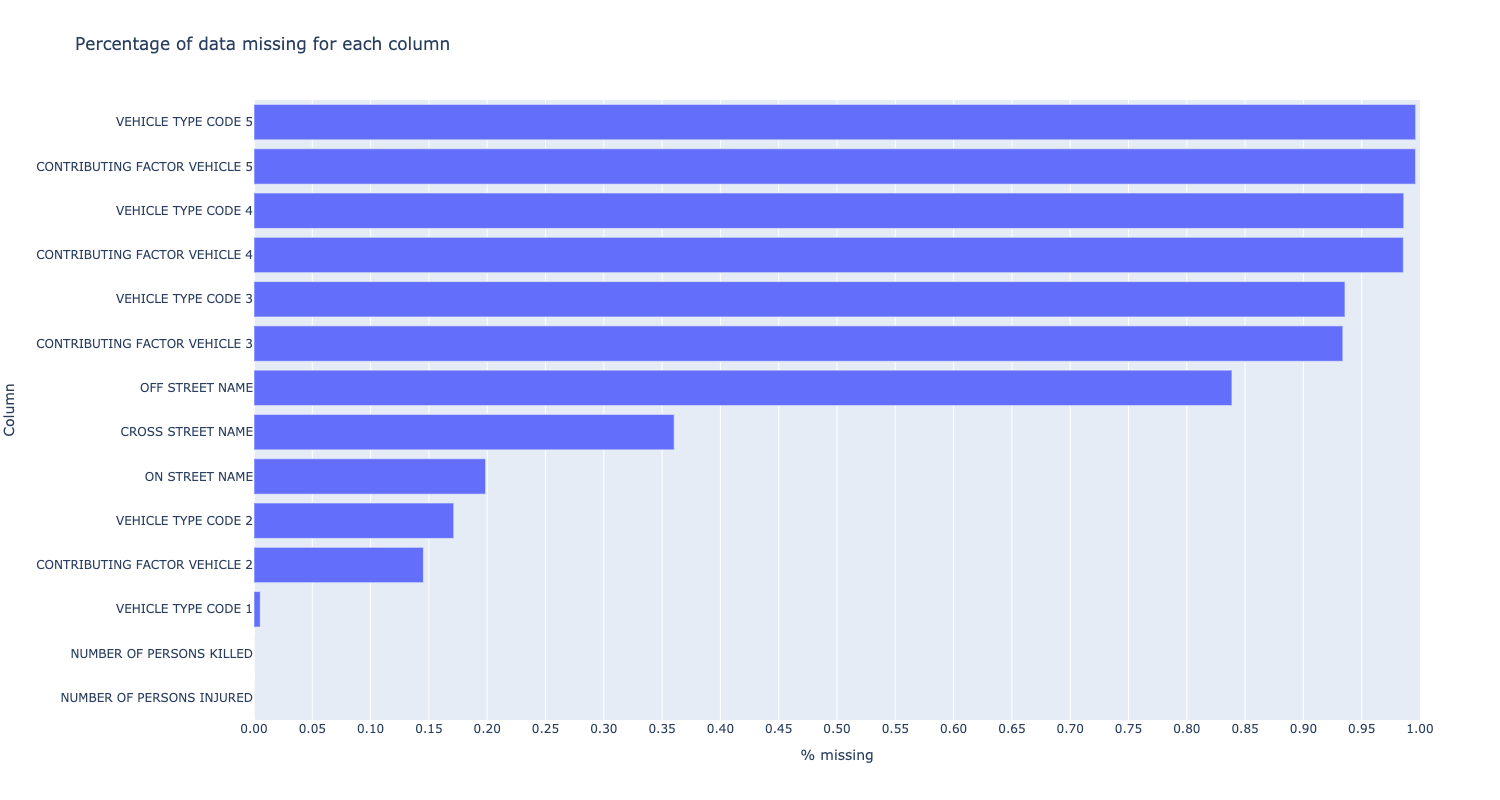

In [167]:
missing_pct_df = pd.DataFrame((df.isnull().sum(axis=0)/len(df)).sort_values(ascending=True)).reset_index(); missing_pct_df.columns = ['Column', 'Percentage missing']
missing_pct_df = missing_pct_df.loc[missing_pct_df['Percentage missing'] > 0]
import plotly.express as px
fig = px.bar(missing_pct_df, x="Percentage missing", y="Column", orientation='h', width = 1000, height=800, title='Percentage of data missing for each column')
fig.update_layout(
    xaxis_title="% missing",
    xaxis = dict(
        tickmode = 'array',
        tickvals = np.arange(0,1.05,0.05),
        ticktext = ['{0:.2f}'.format(x) for x in np.arange(0, 1.05, 0.05)]
    )
)
fig.update_xaxes(range=[0, 1], row=1, col=1)

fig.show()
fig.write_html("./plotly_html/pct_missing_after.html")

In [169]:
df = df.loc[df['NUMBER OF PERSONS KILLED'].fillna(0) == df[[x for x in df.columns if x.endswith('KILLED') and x.find('PERSONS')==-1]].sum(axis=1)]
df = df.loc[df['NUMBER OF PERSONS INJURED'].fillna(0) == df[[x for x in df.columns if x.endswith('INJURED') and x.find('PERSONS')==-1]].sum(axis=1)]

In [171]:
df['NUMBER OF PERSONS KILLED'] = df['NUMBER OF PERSONS KILLED'].fillna(0)
df['NUMBER OF PERSONS INJURED'] = df['NUMBER OF PERSONS INJURED'].fillna(0)

In [172]:
df.to_csv('preprocessed_collisions.csv', index=False)

In [180]:
injured = pd.DataFrame(df.loc[df[['NUMBER OF PERSONS INJURED']].sum(axis=1) > 0].groupby('BOROUGH').size().reset_index().values, columns=['BOROUGH', 'INJURED_N'])
lethal  = pd.DataFrame(df.loc[df[['NUMBER OF PERSONS KILLED']].sum(axis=1) > 0].groupby('BOROUGH').size().reset_index().values, columns=['BOROUGH', 'KILLED_N'])
total   = pd.DataFrame(df.groupby('BOROUGH').size().reset_index().values, columns=['BOROUGH', 'TOTAL_N'])

In [190]:
df_serious = pd.merge(pd.merge(total, lethal, on='BOROUGH'), injured, on='BOROUGH')[['BOROUGH', 'KILLED_N', 'INJURED_N', 'TOTAL_N']]

In [191]:
df_serious['PCT_LETHAL'] = df_serious['KILLED_N'] / df_serious['TOTAL_N']
df_serious['PCT_INJURED'] = df_serious['INJURED_N'] / df_serious['TOTAL_N']


In [193]:
df_serious.sort_values('PCT_LETHAL')

,BOROUGH,KILLED_N,INJURED_N,TOTAL_N,PCT_LETHAL,PCT_INJURED
2,MANHATTAN,286,50320,318391,0.000898,0.158045
1,BROOKLYN,512,96798,434297,0.001179,0.222884
3,QUEENS,531,84327,415658,0.001277,0.202876
4,STATEN ISLAND,90,13309,69734,0.001291,0.190854
0,BRONX,274,46520,211933,0.001293,0.219503
